# Clustering MS/MS spectra with LSH

The algorithm of LSH (locality-sensitive hashing) with random projections allows for the fast identification of highly similar or near-duplicate MS/MS spectra. This notebook first showcases how to apply it to a collection of 200 thousand mass spectra and then discusses the results. If you are interested in how the algorithm works, please refer to [our paper](https://chemrxiv.org/engage/chemrxiv/article-details/6626775021291e5d1d61967f) or [this tutorial on LSH](https://www.pinecone.io/learn/series/faiss/locality-sensitive-hashing-random-projection/).

<p align="center">
  <img src="https://raw.githubusercontent.com/pluskal-lab/DreaMS/b577db12bc8ec0c2010d10854f528007fcc2db2d/assets/lsh.png" width="50%"/>
</p>

In [8]:
# Import all necessary libraries
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import dreams.utils.mols as mu
from dreams.utils.plots import init_plotting
from dreams.utils.spectra import PeakListModifiedCosine
from dreams.utils.data import MSData
from dreams.algorithms.lsh import BatchedPeakListRandomProjection
%reload_ext autoreload
%autoreload 2

As an example, we will use the [MassSpecGym dataset](https://huggingface.co/datasets/roman-bushuiev/MassSpecGym/blob/main/data/auxiliary/MassSpecGym.mgf) in the `.mgf` format. However, other data formats such as `.mzML` are also supported. Please see the last section of this tutorial or refer to the `data_import.ipynb` tutorial for details.

In [5]:
in_pth = Path('../data/MassSpecGym.mgf')
msdata = MSData.from_mgf(in_pth, mol_col='SMILES', adduct_col='ADDUCT')
msdata.get_spectra().shape

Loading dataset MassSpecGym into memory (231104 spectra)...


(231104, 2, 128)

## Computing LSH hashes

Let's initialize the LSH algorithm. The algorithm has two main parameters: `bin_step` and `n_hyperplanes`. `bin_step` defines the width of the m/z range binning window when binning input spectra. `n_hyperplanes` specifies the number of hyperplanes used to split the space of binned spectra into disjoint regions, with each region forming a unique hash. The narrower the binning window and the more hyperplanes used, the more accurate the LSH clustering becomes. For example, if the goal of clustering is to only group near-duplicate spectra, `n_hyperplanes=128` is a good choice. Conversely, if the goal is to cluster structural analogs, `n_hyperplanes=20` may be a better option. Here, we will use `n_hyperplanes=50`, which appears to be a sweet spot (see our paper or [this notebook](https://github.com/pluskal-lab/DreaMS/blob/main/experiments/clustering/clustering_evaluation.ipynb) for details). The second parameter, `bin_step`, does not significantly influence the clustering.

In [6]:
lsh_projector = BatchedPeakListRandomProjection(bin_step=0.5, n_hyperplanes=50)

Let's now compute the LSH hashes. As input, the LSH projector takes MS/MS spectra in the form of a tensor with the shape (num_spectra, 2, num_peaks), where 2 represents the m/z and intensity values. As output, it produces an array of hashes with a length equal to num_spectra.

In [7]:
lshs = lsh_projector.compute(msdata.get_spectra())
lshs.shape

Computing LSHs: 100%|██████████| 231104/231104 [01:09<00:00, 3319.19it/s]


(231104,)

## Understanding LSH hashes and clusters

For 213548 input spectra, LSH projector computed 213548 hashes. Each hash is represented as a string, as we can see by looking at 5 first hashes.

In [9]:
lshs[:5]

array([b'd1595b0fc87e45da6d813214f3f1cf26427e117d0c5c353b9f7f0ba4cefe0e2a',
       b'4e90d6424eb0b9cb1c14668bdf6dcdaf4c4984e2d7e343580fb4da983d468e1a',
       b'4cca6227288b2ea4750e443e89db0c90279372afb58de7df952a39b054b3c7c5',
       b'4848899fa23578eacb2750c65f6d64d9e2473eee94ffd33116ebd5900d1852fb',
       b'c80cecf0ae7687d992a6feceaf70f6c9eb376809a6e6a013584a588d8155b60e'],
      dtype='|S64')

Under the hood, each string is a hashed boolean vector of size `n_hyperplanes`. Each hyperplane divides the space of binned mass spectra into two complementary regions. Consequently, each bit in this vector indicates which region of the space the binned mass spectrum falls into with respect to a specific random hyperplane. To get the boolean vectors instead of the hashed string, one can set `as_str=False`.

In [10]:
lsh_projector.compute(msdata.get_spectra()[:3], as_str=False)

array([[ True,  True,  True, False,  True,  True,  True,  True,  True,
        False, False,  True,  True,  True,  True, False,  True, False,
         True,  True, False,  True,  True,  True,  True, False, False,
         True,  True, False, False, False,  True,  True,  True,  True,
         True, False,  True, False, False, False, False, False,  True,
         True, False, False, False, False],
       [ True,  True,  True, False,  True,  True,  True,  True,  True,
        False, False, False,  True,  True,  True, False,  True, False,
         True,  True, False,  True, False,  True, False, False, False,
         True,  True, False, False,  True,  True, False,  True,  True,
        False,  True,  True, False, False,  True, False, False,  True,
         True, False,  True, False, False],
       [ True,  True,  True, False,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True, False,  True,  True, False,  True, Fal

In [11]:
np.unique(lshs).shape

(133471,)

Given 213,548 spectra, we obtained 164,288 unique LSHs. According to the principle of LSH, similar spectra produce identical hashes. In other words, we efficiently clustered the 213,548 spectra into 164,288 distinct clusters reflecting their spectral similarity.

In [12]:
pd.Series(lshs).value_counts()[:5]

/var/folders/73/x57b4d9x09qbcqjjd5ccz_6r0000gn/T/ipykernel_48126/3293225505.py:1: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  pd.Series(lshs).value_counts()[:5]


b'bfae93ce054b4edc7aa794552cf5223a8c160080e7c8a7b02b6fe3fe8db2f8ee'    6339
b'5b3cff2b5c34fa13f93a8f47abd4a6582ddb49cc5625b368e9d1aba7e5c90d5a'     375
b'36235fd6ed50565f2733dc3de3c9291e1b077d730eef162c6f0ad9c557c56ba5'     248
b'b56df9a9acc1c00ee8ae8f0f407c717da687294d91c3b19fe278fdb03933d7e0'     247
b'670c7ff542d5d07ac07a9b7fd90a58f0aa23d34bcbafec5adab463f33692a67d'     234
Name: count, dtype: int64

The largest cluster contains 6,337 spectra and is represented by the hash bfae93ce054b4edc7aa794552cf5223a8c160080e7c8a7b02b6fe3fe8db2f8ee. Let’s ensure that clusters are formed by similar spectra by inspecting some cluster of 5 spectra.

/var/folders/73/x57b4d9x09qbcqjjd5ccz_6r0000gn/T/ipykernel_48126/1304460116.py:2: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  lsh_counts = pd.Series(lshs).value_counts()


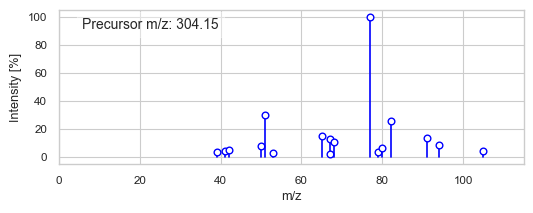

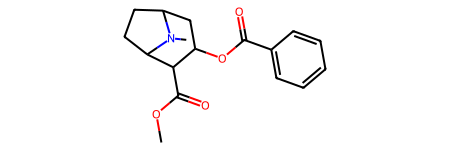

{'COLLISION_ENERGY': 90.0, 'FOLD': 'train', 'FORMULA': 'C17H21NO4', 'IDENTIFIER': 'MassSpecGymID0046269', 'INCHIKEY': 'ZPUCINDJVBIVPJ', 'INSTRUMENT_TYPE': 'QTOF', 'PARENT_MASS': 303.147024, 'PRECURSOR_FORMULA': 'C17H22NO4', 'SIMULATION_CHALLENGE': 'True', 'adduct': '[M+H]+', 'precursor_mz': 304.1543, 'smiles': 'CN1C2CCC1C(C(C2)OC(=O)C3=CC=CC=C3)C(=O)OC'}


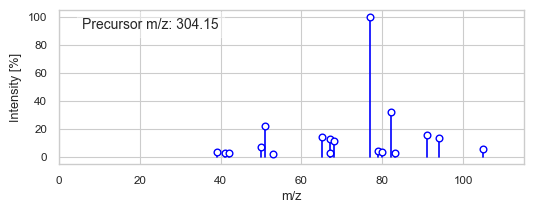

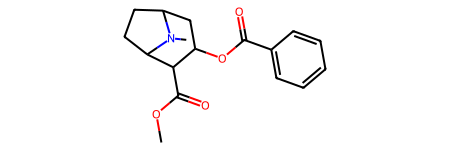

{'COLLISION_ENERGY': 80.0, 'FOLD': 'train', 'FORMULA': 'C17H21NO4', 'IDENTIFIER': 'MassSpecGymID0046270', 'INCHIKEY': 'ZPUCINDJVBIVPJ', 'INSTRUMENT_TYPE': 'QTOF', 'PARENT_MASS': 303.147024, 'PRECURSOR_FORMULA': 'C17H22NO4', 'SIMULATION_CHALLENGE': 'True', 'adduct': '[M+H]+', 'precursor_mz': 304.1543, 'smiles': 'CN1C2CCC1C(C(C2)OC(=O)C3=CC=CC=C3)C(=O)OC'}


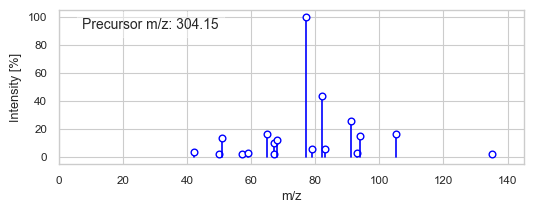

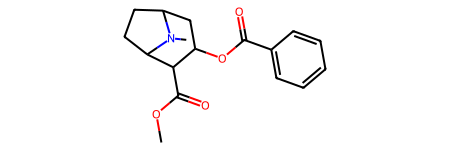

{'COLLISION_ENERGY': 70.0, 'FOLD': 'train', 'FORMULA': 'C17H21NO4', 'IDENTIFIER': 'MassSpecGymID0046272', 'INCHIKEY': 'ZPUCINDJVBIVPJ', 'INSTRUMENT_TYPE': 'QTOF', 'PARENT_MASS': 303.147024, 'PRECURSOR_FORMULA': 'C17H22NO4', 'SIMULATION_CHALLENGE': 'True', 'adduct': '[M+H]+', 'precursor_mz': 304.1543, 'smiles': 'CN1C2CCC1C(C(C2)OC(=O)C3=CC=CC=C3)C(=O)OC'}


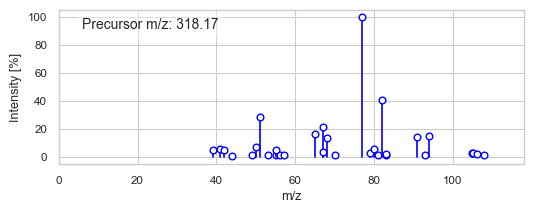

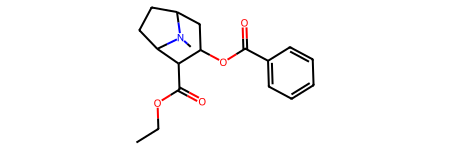

{'COLLISION_ENERGY': 90.0, 'FOLD': 'train', 'FORMULA': 'C18H23NO4', 'IDENTIFIER': 'MassSpecGymID0053777', 'INCHIKEY': 'NMPOSNRHZIWLLL', 'INSTRUMENT_TYPE': 'QTOF', 'PARENT_MASS': 317.162724, 'PRECURSOR_FORMULA': 'C18H24NO4', 'SIMULATION_CHALLENGE': 'True', 'adduct': '[M+H]+', 'precursor_mz': 318.17, 'smiles': 'CCOC(=O)C1C2CCC(N2C)CC1OC(=O)C3=CC=CC=C3'}


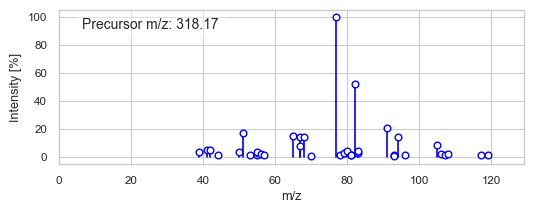

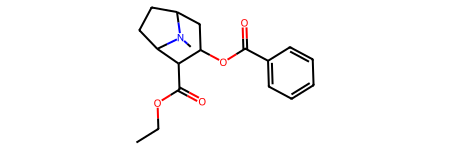

{'COLLISION_ENERGY': 80.0, 'FOLD': 'train', 'FORMULA': 'C18H23NO4', 'IDENTIFIER': 'MassSpecGymID0053787', 'INCHIKEY': 'NMPOSNRHZIWLLL', 'INSTRUMENT_TYPE': 'QTOF', 'PARENT_MASS': 317.162724, 'PRECURSOR_FORMULA': 'C18H24NO4', 'SIMULATION_CHALLENGE': 'True', 'adduct': '[M+H]+', 'precursor_mz': 318.17, 'smiles': 'CCOC(=O)C1C2CCC(N2C)CC1OC(=O)C3=CC=CC=C3'}


In [27]:
# Pick some LSH forming a cluster of 5 spectra
lsh_counts = pd.Series(lshs).value_counts()
lsh_i = lsh_counts[lsh_counts == 5].index[0]
idx = np.where(lshs == lsh_i)[0]

# Display clustered spectra
for i in idx:
    print(msdata.at(int(i), plot_mol=True))

As we can see, all spectra correspond to the same compound measured under different MS conditions (e.g., QTOF and Orbitrap). Notice that the LSH algorithm is robust to noise, which is evident from the signals at > 800 Da in some spectra. We can further verify that all pairs of spectra have high modified cosine similarities.

In [28]:
cos_sim = PeakListModifiedCosine()
cos_sim.compute_pairwise(specs=msdata['spectrum'][idx], prec_mzs=msdata['precursor_mz'][idx], avg=False)

array([[1.        , 0.99355782, 0.95862847, 0.98538179, 0.96166553],
       [0.99355782, 1.        , 0.98095343, 0.99090171, 0.98185785],
       [0.95862847, 0.98095343, 1.        , 0.96813766, 0.98744549],
       [0.98538179, 0.99090171, 0.96813766, 1.        , 0.98466191],
       [0.96166553, 0.98185785, 0.98744549, 0.98466191, 1.        ]])

Note that LSH clustering of mass spectra is designed to be a high-precision, low-recall algorithm. This means that while the clustering allows for the fast detection of near-duplicate spectra, it is conceptually too simple to cluster all different spectra of the same compound or to perfectly approximate modified cosine similarity.

In [29]:
idx_inchi = np.where(np.array(msdata['INCHIKEY']) == 'NMPOSNRHZIWLLL')[0]
idx_inchi.shape

(18,)

The compound representing the selected cluster is present 42 times in the dataset. Let's look into all spectra of this compound.

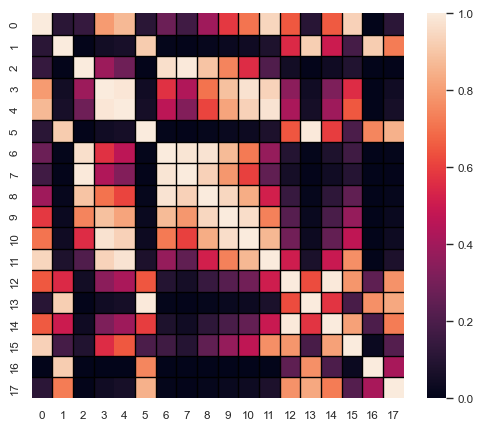

In [30]:
# Sort idx_inchi by their lshs
idx_inchi = idx_inchi[np.argsort(lshs[idx_inchi])]
idx_inchi

# Plot heatmap of pairwise modified cosine similarities
init_plotting(figsize=(6, 5))
sns.heatmap(cos_sim.compute_pairwise(specs=msdata['spectrum'][idx_inchi], prec_mzs=msdata['precursor_mz'][idx_inchi], avg=False), linewidth=0)

# Draw LSH boundaries
for i, (a, b) in enumerate(zip(lshs[idx_inchi], lshs[idx_inchi][1:])):
    if a != b:
        plt.axvline(i + 1, color='black', linewidth=1)
        plt.axhline(i + 1, color='black', linewidth=1)

plt.show()

Each cell (framed with black lines) of the heatmap represents a separate LSH cluster corresponding to the same compound, with colors indicating modified cosine similarities. We observe that the spectra of the same compound are fragmented into different clusters, and not all pairs are connected, indicating low recall. However, all intra-cluster similarities are very high, demonstrating high precision.

Ultimately, we clustered 213,548 spectra in one minute (on a MacBook M1), avoiding pairwise similarity calculations and achieving no false positives with respect to modified cosine similarity (a more systematic evaluation is in the next section). This is the main advantage of LSH compared to other methods. For a more systematic evaluation, please refer to our paper or to [this notebook](https://github.com/pluskal-lab/DreaMS/blob/main/experiments/clustering/clustering_evaluation.ipynb).

## Clustering spectra from a collection of .mzML files

Let's consider a practical example of deduplicating or clustering MS/MS spectra in a large collection of .mzML files. As an example, we will use files representing food samples from [MSV000084900](https://massive.ucsd.edu/ProteoSAFe/dataset.jsp?task=ce3254fe529d43f48077d7ad55b7da09). Although we will work with only three files here, the procedure can be scaled to a larger number of files since only one file is loaded into memory at a time.

In [31]:
# Define path to the directory with mzML files
mzml_dir = Path('../data/MSV00008490')

In [33]:
# Initialize LSH projector and resulting DataFrame
lsh_projector = BatchedPeakListRandomProjection(bin_step=0.5, n_hyperplanes=50)
df = pd.DataFrame()

# Iterate over all .mzML files in the directory
for p in mzml_dir.glob('*.mzML'):
    print(f'Processing {p}...')

    # Read spectra from .mzML file
    msdata = MSData.from_mzml(p)

    # Compute LSHs and store them with corresponding file_name and scan_numbers
    df = pd.concat([df, pd.DataFrame({
        'file_name': msdata.get_values('file_name'),
        'scan_number': msdata.get_values('scan_number'),
        'lsh': lsh_projector.compute(msdata.get_spectra())
    })])
df

/Users/builder/jenkins/ws/enms_ntly_pyoms_whl_Release3.0.0/OpenMS/src/openms/source/FORMAT/HANDLERS/XMLHandler.cpp(130): While loading '../data/MSV00008490/G73954_1x_BC8_01_17287.mzML': Required attribute 'softwareRef' not present!


Processing ../data/MSV00008490/G73954_1x_BC8_01_17287.mzML...
Loading dataset G73954_1x_BC8_01_17287 into memory (1930 spectra)...


Computing LSHs: 100%|██████████| 1930/1930 [00:00<00:00, 3349.27it/s]
/Users/builder/jenkins/ws/enms_ntly_pyoms_whl_Release3.0.0/OpenMS/src/openms/source/FORMAT/HANDLERS/XMLHandler.cpp(130): While loading '../data/MSV00008490/G87408_1x_BD5_01_26032.mzML': Required attribute 'softwareRef' not present!


Processing ../data/MSV00008490/G87408_1x_BD5_01_26032.mzML...
Loading dataset G87408_1x_BD5_01_26032 into memory (1353 spectra)...


Computing LSHs: 100%|██████████| 1353/1353 [00:00<00:00, 3404.85it/s]
/Users/builder/jenkins/ws/enms_ntly_pyoms_whl_Release3.0.0/OpenMS/src/openms/source/FORMAT/HANDLERS/XMLHandler.cpp(130): While loading '../data/MSV00008490/G72676_BB5_01_18927.mzML': Required attribute 'softwareRef' not present!


Processing ../data/MSV00008490/G72676_BB5_01_18927.mzML...
Loading dataset G72676_BB5_01_18927 into memory (2308 spectra)...


Computing LSHs: 100%|██████████| 2308/2308 [00:00<00:00, 3379.47it/s]
/Users/builder/jenkins/ws/enms_ntly_pyoms_whl_Release3.0.0/OpenMS/src/openms/source/FORMAT/HANDLERS/XMLHandler.cpp(130): While loading '../data/MSV00008490/G83331_1x_RF3_01_21829.mzML': Required attribute 'softwareRef' not present!


Processing ../data/MSV00008490/G83331_1x_RF3_01_21829.mzML...
Loading dataset G83331_1x_RF3_01_21829 into memory (1470 spectra)...


Computing LSHs: 100%|██████████| 1470/1470 [00:00<00:00, 3386.33it/s]
/Users/builder/jenkins/ws/enms_ntly_pyoms_whl_Release3.0.0/OpenMS/src/openms/source/FORMAT/HANDLERS/XMLHandler.cpp(130): While loading '../data/MSV00008490/G75653_5x_BH3_01_19360.mzML': Required attribute 'softwareRef' not present!


Processing ../data/MSV00008490/G75653_5x_BH3_01_19360.mzML...
Loading dataset G75653_5x_BH3_01_19360 into memory (1851 spectra)...


Computing LSHs: 100%|██████████| 1851/1851 [00:00<00:00, 3409.90it/s]


,file_name,scan_number,lsh
0,G73954_1x_BC8_01_17287.mzML,2,b'da1d05deaf9942f8ad5ff66bec1d274b9a2afc4cf508...
1,G73954_1x_BC8_01_17287.mzML,3,b'f82876086f9da8d10033330b031c51964b0a3d3aee85...
2,G73954_1x_BC8_01_17287.mzML,4,b'cd8c4b381a3fcb4e39339e5f82811f0c6fd333d9472b...
3,G73954_1x_BC8_01_17287.mzML,8,b'da1d05deaf9942f8ad5ff66bec1d274b9a2afc4cf508...
4,G73954_1x_BC8_01_17287.mzML,9,b'1d6d296e796d14296f3b69bcd98f0e855984f249dfe6...
...,...,...,...
1846,G75653_5x_BH3_01_19360.mzML,3030,b'0c5187cb9da473d5fdb75f26ac7a1d400996cbab0e96...
1847,G75653_5x_BH3_01_19360.mzML,3033,b'23388206af220e02b007f1b20dfd7e6acf911459e24d...
1848,G75653_5x_BH3_01_19360.mzML,3034,b'82f2b27ac666438582383c0daf884e14b82ab740b71a...
1849,G75653_5x_BH3_01_19360.mzML,3037,b'23388206af220e02b007f1b20dfd7e6acf911459e24d...


The resulting DataFrame contains LSH hashes merged from all three files. It also includes `file_name` and `scan_number` columns, allowing for tracing the corresponding spectra. Note that the `MSData.from_mzml` method creates an .hdf5 file for each input .mzML file, so the spectra or information from .mzML files can also be retrieved from the converted files (please see details in `data_import.ipynb` tutorial). The spectra can now be clustered by simply deduplicating their LSHs.

In [34]:
print(f'Number of spectra before LSH clustering: {len(df)}')
df = df.drop_duplicates(subset=['lsh'])
print(f'Number of spectra after LSH clustering: {len(df)}')

Number of spectra before LSH clustering: 8912
Number of spectra after LSH clustering: 6095
